In [5]:
import json
import psycopg2
import pandas as pd

#this is a .json with my credentials, see also update-department-boundaries...
#for a more convenient approach using your pg_conf file
#with open('../config.json') as f:
#    conf = json.load(f)


In [6]:
#conn_str = "host={host} dbname={database} user={user} password={passw} port={port}".format(**conf)

In [7]:
conn = psycopg2.connect('service=firecares-austin')

In [8]:
bigquery = """select r.department_id, round(s.yravg,2) as yravg_fires, round(r.risk_model_fires::numeric,2) as predicted_fires, 
round((s.yravg - r.risk_model_fires)::numeric,2) as residuals,
round((abs(s.yravg - r.risk_model_fires)/(s.yravg))::numeric,2) as normedresiduals, 
fd.name from 
firestation_firedepartmentriskmodels r
	inner join (select fire_department_id, avg(count) as yravg from firestation_nfirsstatistic where metric='residential_structure_fires'
and count is not null and year >= 2010 and level = 0 group by fire_department_id) s
	on r.department_id = s.fire_department_id
	inner join firestation_firedepartment fd on r.department_id = fd.id
where r.level = 0 and r.risk_model_fires is not null order by normedresiduals asc
"""

In [9]:
df = pd.read_sql(bigquery,con=conn)

In [10]:
df.head()

,department_id,yravg_fires,predicted_fires,residuals,normedresiduals,name
0,73695,83.33,83.06,0.27,0.0,Anniston Fire Department
1,85843,52.43,52.21,0.22,0.0,Klamath County Fire District 1
2,77786,108.71,108.23,0.48,0.0,City of Murfreesboro Fire & Rescue Department ...
3,94133,293.57,292.11,1.46,0.0,Saint Petersburg Fire & Rescue Station
4,77489,554.71,555.84,-1.12,0.0,Cincinnati Fire Department


In [7]:
# 90% of fire departments reporting more than 100 incidents have predicted values within about 600 incidents of the true value.
df.residuals.describe()

count     2578.000000
mean       -37.936955
std        604.690780
min     -29973.210000
25%        -22.060000
50%         -9.265000
75%         -0.142500
max       1623.010000
Name: residuals, dtype: float64

In [9]:
df.normedresiduals.describe()

count    2578.000000
mean        1.175710
std         7.670356
min         0.000000
25%         0.320000
50%         0.730000
75%         1.060000
max       371.040000
Name: normedresiduals, dtype: float64

In [12]:
df[(df.residuals < 1000) & (df.residuals > -1000) & (df.yravg_fires > 10)].head()

,department_id,yravg_fires,predicted_fires,residuals,normedresiduals,name
0,73695,83.33,83.06,0.27,0.0,Anniston Fire Department
1,85843,52.43,52.21,0.22,0.0,Klamath County Fire District 1
2,77786,108.71,108.23,0.48,0.0,City of Murfreesboro Fire & Rescue Department ...
3,94133,293.57,292.11,1.46,0.0,Saint Petersburg Fire & Rescue Station
4,77489,554.71,555.84,-1.12,0.0,Cincinnati Fire Department


In [14]:
df[(abs(df.normedresiduals) < 0.5)].head()

,department_id,yravg_fires,predicted_fires,residuals,normedresiduals,name
0,73695,83.33,83.06,0.27,0.0,Anniston Fire Department
1,85843,52.43,52.21,0.22,0.0,Klamath County Fire District 1
2,77786,108.71,108.23,0.48,0.0,City of Murfreesboro Fire & Rescue Department ...
3,94133,293.57,292.11,1.46,0.0,Saint Petersburg Fire & Rescue Station
4,77489,554.71,555.84,-1.12,0.0,Cincinnati Fire Department


In [51]:
cumulator = df.apply(lambda x: x.name/df.shape[0],axis=1)
df = df.assign(cumulativefreq=cumulator)

In [33]:
import holoviews as hv
hv.extension('matplotlib')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [46]:
import numpy as np

out=hv.Histogram(np.histogram(df.normedresiduals[df.normedresiduals <= 3],range=(0,3)))

In [47]:
out = out.opts(title='Fire Departments by Model Residual Error',
               xlabel='Normalized Residual Error',
               ylabel='# of FDs',
               fontsize={'title':16,'xlabel':16,'ylabel':16,'xticks':14,'yticks':14},
               fig_size=200)

In [48]:
hv.save(out,'FDresidualhistogram.png')

In [54]:
residtable = hv.Table(df[['normedresiduals','cumulativefreq']],vdims='cumulativefreq')

:Curve   [normedresiduals]   (cumulativefreq)
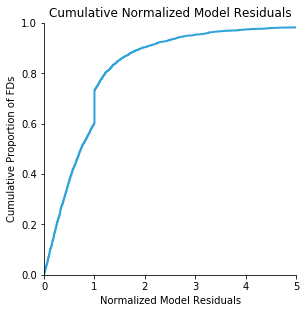

In [61]:
hv.Curve(residtable).opts(title='Cumulative Normalized Model Residuals',
                          xlabel='Normalized Model Residuals',
                          ylabel='Cumulative Proportion of FDs',
                          xlim=(0,5),
                          fig_size=125)